In [28]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [29]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [30]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [31]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_data = np.load(os.path.join(data_dir, 'train_data.npz'))
val_data = np.load(os.path.join(data_dir, 'validation_data.npz'))
test_data = np.load(os.path.join(data_dir, 'test_data.npz'))

In [ ]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 25443),
 (36805,),
 (4293, 25443),
 (4293,),
 (4815, 25443),
 (4815,),
 (16, 2))

In [ ]:
def preprocess(x_data):
    x_data = np.reshape(x_data, [x_data.shape[0], 99, 257, 1])
    x_data = np.rot90(x_data, 1, (1, 2))
    return x_data

In [ ]:
output_size = y_table.shape[0]

In [ ]:
x_train_2d = preprocess(x_train)
mean_vals = np.mean(x_train_2d, axis=0)
std_val = np.std(x_train_2d)
x_train_2d_norm = (x_train_2d-mean_vals) / std_val
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_2d = preprocess(x_val)
x_val_2d_norm = (x_val_2d-mean_vals) / std_val
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_2d = preprocess(x_test)
x_test_2d_norm = (x_test_2d-mean_vals) / std_val
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [ ]:
input_shape = x_test_2d_norm[0].shape

In [ ]:
def build_2d_cnn_only_conv_ch_64_DO(conv_num=1):
    input_layer = Input(shape=input_shape)
    x = input_layer
    
    for i in range(conv_num):
        x = Conv2D(kernel_size=5, filters=64*(2**int((i)/2)), strides=(1,1), padding='valid')(x)
#         x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=2, strides=(2,2), padding='same')(x)

    x = Flatten()(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [ ]:
for i in range(1, 5):
    model = build_2d_cnn_only_conv_ch_64_DO(conv_num=i)
    model.summary()
    del model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 257, 99, 1)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 253, 95, 64)       1664      
_________________________________________________________________
activation_24 (Activation)   (None, 253, 95, 64)       0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 127, 48, 64)       0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 390144)            0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 390144)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                6242320   
Total para

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5233 - acc: 0.5487
Epoch 00001: val_loss improved from inf to 1.35907, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_1_conv_DO_checkpoint/001-1.3591.hdf5
36805/36805 [==============================] - 26s 715us/sample - loss: 1.5232 - acc: 0.5487 - val_loss: 1.3591 - val_acc: 0.6061
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0862 - acc: 0.6802
Epoch 00002: val_loss improved from 1.35907 to 1.19588, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_1_conv_DO_checkpoint/002-1.1959.hdf5
36805/36805 [==============================] - 26s 717us/sample - loss: 1.0862 - acc: 0.6802 - val_loss: 1.1959 - val_acc: 0.6585
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8675 - acc: 0.7405
Epoch 00003: val_loss improved from 1.19588 to 1.07517, saving model to model/checkpoint/2D_CNN_only_conv_ch_

36800/36805 [============================>.] - ETA: 0s - loss: 0.1145 - acc: 0.9699
Epoch 00029: val_loss did not improve from 1.07517
36805/36805 [==============================] - 24s 659us/sample - loss: 0.1145 - acc: 0.9699 - val_loss: 1.4977 - val_acc: 0.7445
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1097 - acc: 0.9718
Epoch 00030: val_loss did not improve from 1.07517
36805/36805 [==============================] - 24s 662us/sample - loss: 0.1097 - acc: 0.9718 - val_loss: 1.5055 - val_acc: 0.7433
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1083 - acc: 0.9707
Epoch 00031: val_loss did not improve from 1.07517
36805/36805 [==============================] - 24s 664us/sample - loss: 0.1082 - acc: 0.9707 - val_loss: 1.5032 - val_acc: 0.7424
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0987 - acc: 0.9740
Epoch 00032: val_loss did not improve from 1.07517
36805/36805 [==================

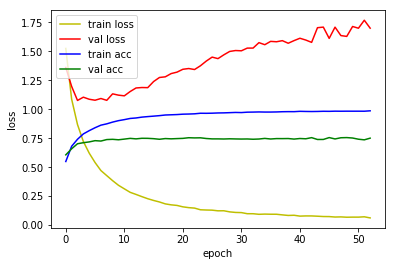

4815/4815 [==============================] - 2s 334us/sample - loss: 1.1698 - acc: 0.6719
Loss: 1.1698153148435235 Accuracy: 0.6718588

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3460 - acc: 0.5938
Epoch 00001: val_loss improved from inf to 0.87627, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_2_conv_DO_checkpoint/001-0.8763.hdf5
36805/36805 [==============================] - 32s 869us/sample - loss: 1.3460 - acc: 0.5938 - val_loss: 0.8763 - val_acc: 0.7615
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7256 - acc: 0.7867
Epoch 00002: val_loss improved from 0.87627 to 0.62231, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_2_conv_DO_checkpoint/002-0.6223.hdf5
36805/36805 [==============================] - 30s 808us/sample - loss: 0.7256 - acc: 0.7867 - val_loss: 0.6223 - val_acc: 0.8344
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0457 - acc: 0.9866
Epoch 00027: val_loss did not improve from 0.44392
36805/36805 [==============================] - 30s 807us/sample - loss: 0.0457 - acc: 0.9866 - val_loss: 0.5644 - val_acc: 0.9045
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0432 - acc: 0.9884
Epoch 00028: val_loss did not improve from 0.44392
36805/36805 [==============================] - 30s 804us/sample - loss: 0.0432 - acc: 0.9884 - val_loss: 0.5641 - val_acc: 0.9082
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0379 - acc: 0.9886
Epoch 00029: val_loss did not improve from 0.44392
36805/36805 [==============================] - 30s 806us/sample - loss: 0.0379 - acc: 0.9886 - val_loss: 0.5627 - val_acc: 0.9096
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0423 - acc: 0.9874
Epoch 00030: val_loss did not improve from 0.44392
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.0187 - acc: 0.9953
Epoch 00056: val_loss did not improve from 0.44392
36805/36805 [==============================] - 30s 809us/sample - loss: 0.0187 - acc: 0.9953 - val_loss: 0.6519 - val_acc: 0.9073
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0210 - acc: 0.9943
Epoch 00057: val_loss did not improve from 0.44392
36805/36805 [==============================] - 30s 807us/sample - loss: 0.0210 - acc: 0.9943 - val_loss: 0.6536 - val_acc: 0.9073
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0203 - acc: 0.9947
Epoch 00058: val_loss did not improve from 0.44392
36805/36805 [==============================] - 30s 812us/sample - loss: 0.0203 - acc: 0.9947 - val_loss: 0.6345 - val_acc: 0.9080
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0196 - acc: 0.9950
Epoch 00059: val_loss did not improve from 0.44392
36805/36805 [==================

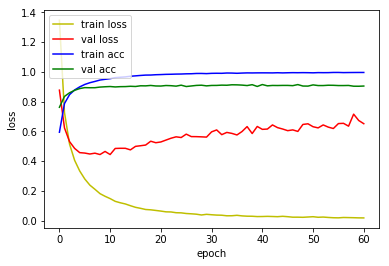

4815/4815 [==============================] - 2s 439us/sample - loss: 0.5633 - acc: 0.8714
Loss: 0.5632682611637769 Accuracy: 0.8714434

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3095 - acc: 0.5995
Epoch 00001: val_loss improved from inf to 0.66956, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_3_conv_DO_checkpoint/001-0.6696.hdf5
36805/36805 [==============================] - 34s 931us/sample - loss: 1.3094 - acc: 0.5995 - val_loss: 0.6696 - val_acc: 0.8248
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6231 - acc: 0.8130
Epoch 00002: val_loss improved from 0.66956 to 0.46613, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_3_conv_DO_checkpoint/002-0.4661.hdf5
36805/36805 [==============================] - 33s 892us/sample - loss: 0.6231 - acc: 0.8130 - val_loss: 0.4661 - val_acc: 0.8714
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0463 - acc: 0.9850
Epoch 00026: val_loss did not improve from 0.23810
36805/36805 [==============================] - 33s 896us/sample - loss: 0.0463 - acc: 0.9850 - val_loss: 0.3097 - val_acc: 0.9450
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0458 - acc: 0.9854
Epoch 00027: val_loss did not improve from 0.23810
36805/36805 [==============================] - 33s 898us/sample - loss: 0.0458 - acc: 0.9854 - val_loss: 0.2917 - val_acc: 0.9420
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0418 - acc: 0.9873
Epoch 00028: val_loss did not improve from 0.23810
36805/36805 [==============================] - 33s 896us/sample - loss: 0.0418 - acc: 0.9873 - val_loss: 0.2970 - val_acc: 0.9490
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0415 - acc: 0.9877
Epoch 00029: val_loss did not improve from 0.23810
36805/36805 [=====

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0183 - acc: 0.9943
Epoch 00056: val_loss did not improve from 0.23810
36805/36805 [==============================] - 33s 895us/sample - loss: 0.0183 - acc: 0.9943 - val_loss: 0.3171 - val_acc: 0.9520
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0190 - acc: 0.9939
Epoch 00057: val_loss did not improve from 0.23810
36805/36805 [==============================] - 33s 894us/sample - loss: 0.0190 - acc: 0.9939 - val_loss: 0.3320 - val_acc: 0.9513
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0202 - acc: 0.9937
Epoch 00058: val_loss did not improve from 0.23810
36805/36805 [==============================] - 33s 898us/sample - loss: 0.0202 - acc: 0.9937 - val_loss: 0.3430 - val_acc: 0.9483
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0195 - acc: 0.9946
Epoch 00059: val_loss did not improve from 0.23810
36805/36805 [=====

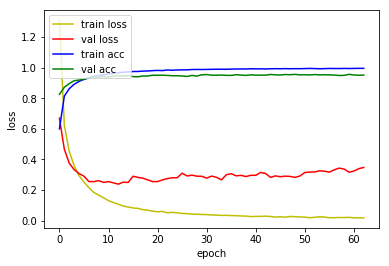

4815/4815 [==============================] - 2s 442us/sample - loss: 0.3228 - acc: 0.9165
Loss: 0.3228353184053088 Accuracy: 0.9165109

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5004 - acc: 0.5289
Epoch 00001: val_loss improved from inf to 0.68623, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_4_conv_DO_checkpoint/001-0.6862.hdf5
36805/36805 [==============================] - 36s 989us/sample - loss: 1.5003 - acc: 0.5290 - val_loss: 0.6862 - val_acc: 0.8174
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7063 - acc: 0.7861
Epoch 00002: val_loss improved from 0.68623 to 0.42377, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_4_conv_DO_checkpoint/002-0.4238.hdf5
36805/36805 [==============================] - 34s 930us/sample - loss: 0.7062 - acc: 0.7861 - val_loss: 0.4238 - val_acc: 0.8828
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0671 - acc: 0.9778
Epoch 00025: val_loss did not improve from 0.16436
36805/36805 [==============================] - 35s 938us/sample - loss: 0.0670 - acc: 0.9778 - val_loss: 0.1996 - val_acc: 0.9574
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0626 - acc: 0.9796
Epoch 00026: val_loss did not improve from 0.16436
36805/36805 [==============================] - 35s 939us/sample - loss: 0.0626 - acc: 0.9795 - val_loss: 0.1763 - val_acc: 0.9604
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0651 - acc: 0.9790
Epoch 00027: val_loss did not improve from 0.16436
36805/36805 [==============================] - 35s 939us/sample - loss: 0.0651 - acc: 0.9790 - val_loss: 0.1885 - val_acc: 0.9604
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0597 - acc: 0.9795
Epoch 00028: val_loss did not improve from 0.16436
36805/36805 [=====

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0277 - acc: 0.9917
Epoch 00055: val_loss did not improve from 0.16436
36805/36805 [==============================] - 35s 939us/sample - loss: 0.0277 - acc: 0.9917 - val_loss: 0.2362 - val_acc: 0.9623
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0249 - acc: 0.9920
Epoch 00056: val_loss did not improve from 0.16436
36805/36805 [==============================] - 35s 939us/sample - loss: 0.0249 - acc: 0.9920 - val_loss: 0.2203 - val_acc: 0.9672
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0313 - acc: 0.9907
Epoch 00057: val_loss did not improve from 0.16436
36805/36805 [==============================] - 35s 940us/sample - loss: 0.0313 - acc: 0.9907 - val_loss: 0.2195 - val_acc: 0.9634
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0266 - acc: 0.9916
Epoch 00058: val_loss did not improve from 0.16436
36805/36805 [=====

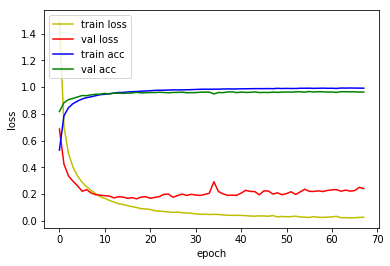

4815/4815 [==============================] - 2s 431us/sample - loss: 0.2354 - acc: 0.9360
Loss: 0.2354274610376618 Accuracy: 0.93603325



In [ ]:
for i in range(1, 5):
    model_name = '2D_CNN_only_conv_ch_64_{}_conv_DO'.format(i)
    model = build_2d_cnn_only_conv_ch_64_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_2d_norm, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_2d_norm, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)
    
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [ ]:
for i in range(1, 5):
    model_name = '2D_CNN_only_conv_ch_64_{}_conv_DO'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


2D_CNN_only_conv_ch_64_1_conv_DO Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 257, 99, 1)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 253, 95, 64)       1664      
_________________________________________________________________
activation_34 (Activation)   (None, 253, 95, 64)       0         
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 127, 48, 64)       0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 390144)            0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 390144)            0         
_________________________________________________________________
dense_15 (Dense)             (None, 

In [ ]:
def build_2d_cnn_only_conv_ch_64_BN(conv_num=1):
    input_layer = Input(shape=input_shape)
    x = input_layer
    
    for i in range(conv_num):
        x = Conv2D(kernel_size=5, filters=64*(2**int((i)/2)), strides=(1,1), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=2, strides=(2,2), padding='same')(x)

    x = Flatten()(x)
    x = BatchNormalization()(x)
    output_layer = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [ ]:
for i in range(1, 5):
    model = build_2d_cnn_only_conv_ch_64_BN(conv_num=i)
    model.summary()
    del model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 257, 99, 1)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 253, 95, 64)       1664      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 253, 95, 64)       256       
_________________________________________________________________
activation_44 (Activation)   (None, 253, 95, 64)       0         
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 127, 48, 64)       0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 390144)            0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 390144)            1560576   
__________

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.0820 - acc: 0.5304
Epoch 00001: val_loss improved from inf to 2.88656, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_1_conv_BN_checkpoint/001-2.8866.hdf5
36805/36805 [==============================] - 43s 1ms/sample - loss: 3.0823 - acc: 0.5303 - val_loss: 2.8866 - val_acc: 0.5246
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4871 - acc: 0.7558
Epoch 00002: val_loss improved from 2.88656 to 2.44466, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_1_conv_BN_checkpoint/002-2.4447.hdf5
36805/36805 [==============================] - 40s 1ms/sample - loss: 1.4874 - acc: 0.7558 - val_loss: 2.4447 - val_acc: 0.6278
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8891 - acc: 0.8454
Epoch 00003: val_loss improved from 2.44466 to 2.42812, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_1

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2312 - acc: 0.9726
Epoch 00029: val_loss did not improve from 2.40020
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.2311 - acc: 0.9726 - val_loss: 3.5816 - val_acc: 0.6741
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2188 - acc: 0.9745
Epoch 00030: val_loss did not improve from 2.40020
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.2193 - acc: 0.9745 - val_loss: 3.6359 - val_acc: 0.6734
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2420 - acc: 0.9726
Epoch 00031: val_loss did not improve from 2.40020
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.2424 - acc: 0.9725 - val_loss: 3.6204 - val_acc: 0.6753
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2127 - acc: 0.9760
Epoch 00032: val_loss did not improve from 2.40020
36805/36805 [===========

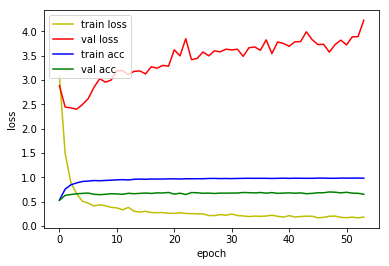

4815/4815 [==============================] - 2s 501us/sample - loss: 2.7804 - acc: 0.6305
Loss: 2.780429733331825 Accuracy: 0.6305296

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4477 - acc: 0.6166
Epoch 00001: val_loss improved from inf to 1.35166, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_2_conv_BN_checkpoint/001-1.3517.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 1.4477 - acc: 0.6166 - val_loss: 1.3517 - val_acc: 0.6101
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5918 - acc: 0.8294
Epoch 00002: val_loss improved from 1.35166 to 0.88501, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_2_conv_BN_checkpoint/002-0.8850.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.5919 - acc: 0.8294 - val_loss: 0.8850 - val_acc: 0.7717
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss:

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0292 - acc: 0.9915
Epoch 00029: val_loss did not improve from 0.73832
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0292 - acc: 0.9915 - val_loss: 0.9620 - val_acc: 0.8553
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0227 - acc: 0.9938
Epoch 00030: val_loss did not improve from 0.73832
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0230 - acc: 0.9938 - val_loss: 1.2013 - val_acc: 0.8262
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0360 - acc: 0.9902
Epoch 00031: val_loss did not improve from 0.73832
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0360 - acc: 0.9902 - val_loss: 1.1158 - val_acc: 0.8395
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0175 - acc: 0.9950
Epoch 00032: val_loss did not improve from 0.73832
36805/36805 [===========

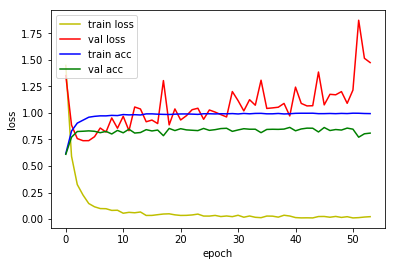

4815/4815 [==============================] - 3s 555us/sample - loss: 0.8255 - acc: 0.7985
Loss: 0.825529545935515 Accuracy: 0.7985462

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2399 - acc: 0.6413
Epoch 00001: val_loss improved from inf to 0.81419, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_3_conv_BN_checkpoint/001-0.8142.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 1.2402 - acc: 0.6413 - val_loss: 0.8142 - val_acc: 0.7556
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5645 - acc: 0.8352
Epoch 00002: val_loss improved from 0.81419 to 0.61193, saving model to model/checkpoint/2D_CNN_only_conv_ch_64_3_conv_BN_checkpoint/002-0.6119.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.5648 - acc: 0.8352 - val_loss: 0.6119 - val_acc: 0.8495
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss:

In [ ]:
for i in range(1, 5):
    model_name = '2D_CNN_only_conv_ch_64_{}_conv_BN'.format(i)
    model = build_2d_cnn_only_conv_ch_64_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_2d_norm, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_2d_norm, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)
    
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [ ]:
for i in range(1, 5):
    model_name = '2D_CNN_only_conv_ch_64_{}_conv_BN'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

In [ ]:
def build_2d_cnn_only_conv_ch_64_DO_BN(conv_num=1):
    input_layer = Input(shape=input_shape)
    x = input_layer
    
    for i in range(conv_num):
        x = Conv2D(kernel_size=5, filters=64*(2**int((i)/2)), strides=(1,1), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=2, strides=(2,2), padding='same')(x)

    x = Flatten()(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [ ]:
for i in range(1, 5):
    model = build_2d_cnn_only_conv_ch_64_DO_BN(conv_num=i)
    model.summary()
    del model

In [ ]:
for i in range(1, 5):
    model_name = '2D_CNN_only_conv_ch_64_{}_conv_DO_BN'.format(i)
    model = build_2d_cnn_only_conv_ch_64_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_2d_norm, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_2d_norm, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)
    
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [ ]:
for i in range(1, 5):
    model_name = '2D_CNN_only_conv_ch_64_{}_conv_BN'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)